In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Defining the model for cancer

def model_update(states, drug_infusion):
    dt = 0.01
    normal, tumor, immune, drug_con = states
    parameters_a = [0.2,0.3,0.1]
    parameters_b = [1,1]
    parameters_c = [1,0.5,1,1]
    parameters_d = [0.2,1]
    parameters_r = [1.5,1]
    s = 0.33
    alpha = 0.3
    rho = 0.01
    N=int(1//dt)
    for n in range(0,N):
        pre_normal, pre_tumor, pre_immune, pre_drug_con = normal, tumor, immune, drug_con
        normal+=(parameters_r[1]*pre_normal*(1-parameters_b[1]*pre_normal)
                 -parameters_c[3]*pre_normal*pre_tumor
                 -parameters_a[2]*pre_normal*pre_drug_con)*dt
        tumor+=(parameters_r[0]*pre_tumor*(1-parameters_b[0]*pre_tumor)
                -parameters_c[1]*pre_immune*pre_tumor
                -parameters_c[2]*pre_tumor*pre_normal
                -parameters_a[1]*pre_tumor*pre_drug_con)*dt
        immune+=(s+(rho*pre_immune*pre_tumor)/(alpha+pre_tumor)
                 -parameters_c[0]*pre_immune*pre_tumor
                 -parameters_d[0]*pre_immune
                 -parameters_a[0]*pre_immune*pre_drug_con)*dt
        drug_con+=(-parameters_d[1]*pre_drug_con
                   +drug_infusion)*dt

    return [normal, tumor, immune, drug_con]

In [3]:
u_max=10
action_space = np.linspace(0,u_max,num=50) # Defining the action space
state_space = np.arange(0,20,1) # Defining the state space
state_table=[
    0.0063,0.0125,0.025,
    0.01,0.05,0.1,0.2,0.25,
    0.3,0.35,0.4,0.45,0.5,0.55,
    0.6,0.65,0.7,0.8,0.9,np.inf
    ]

def state_numbered(tumor_count):
    ix = 0
    while tumor_count>state_table[ix]:
        ix+=1
    return ix

In [4]:
# Q Learning

def reward(e_1,e_2):
    if e_2<e_1:
        return (e_1-e_2)/e_1
    return 0

q_table=np.zeros([len(state_space), len(action_space)])

for i in range(20000):
    model = np.random.random(4)
    state = state_numbered(model[1])

    tumor_counts = [model[1]]

    a=0.1
    g=0.6
    epsilon=0.1
    done = False
    while not done:
        p = np.random.random()
        if p<epsilon:
            ix = np.random.randint(0,len(action_space))
            action = action_space[ix]
        else:
            ix = np.argmax(q_table[state])
            action = action_space[ix]
        
        model = model_update(model, action)
        next_state = state_numbered(model[1])
        r = reward(tumor_counts[-1], model[1])
        tumor_counts.append(model[1])
        if next_state==0:
            done=True

        old_value = q_table[state,ix]
        next_max = np.max(q_table[next_state])

        new_value = old_value+g*(r+g*next_max-old_value) 
        q_table[state,ix]=new_value
        state = next_state
    if i%1000==0:
        print(f"Episode: {i}")

Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000
Episode: 10000
Episode: 11000
Episode: 12000
Episode: 13000
Episode: 14000
Episode: 15000
Episode: 16000
Episode: 17000
Episode: 18000
Episode: 19000


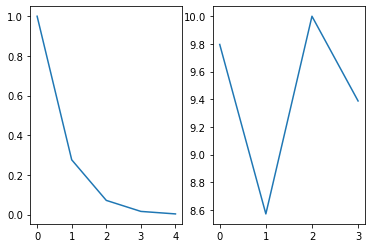

In [5]:
# Evaluating the model

model = [0.6,1,0.9,0.5]
states = [model[1]]
actions = []
done = False

while not done:
    numbered_state = state_numbered(states[-1])
    action = action_space[np.argmax(q_table[numbered_state])]
    model = model_update(model, action)
    actions.append(action)
    states.append(model[1])
    if state_numbered(states[-1])==0:
        done = True

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(len(states)), states)
ax2.plot(range(len(actions)), actions)
plt.show()